Updates:

11/21/2016
- Added PoissonInput to select subgroup of NeuronGroup
- Introduced refractoriness

11/19/2016
- Integrated weight and adjacency matrix from NetworkX to Brian
- Defined unidirectional connections, i.e. 0 -> 1, not 1 -> 0
- Used absolute value of weights for Synapses group

11/13/2016
- Added peri stimulus time histogram (PSTH) capability 

11/12/2016
- Finalized function 4 to visualize different Brian parameters

Questions:

1. Given PoissonInput, do I still need to add noise (even if Bruno's model can't accomodate for it, because then we wouldn't be able to accurately compare between FPGA and Brian)
    - Add noise so that raster plot is not the same time frame just with shifting start time
    - need different input for each neuron or have noise (changes from 2Hz to 4 over time)
    - or different input currents
    - important b/c looking at individual neurons
    - when looking at network --> each neuron input from other neurons --> would get rid of
    - side effect that oscillation is the same for each neuron

To do:
1. Change color of neurons in raster plot that receiving PoissonInput (did this but very slow b/c was monitoring more neurons so slowed down significantly)

2. Plot instantaneous firing rate of population over time

3. Figure out how to have dynamic plot (similar to oscilloscope) to observe changes in real-time

4. Find best visualization of synchronicity

5. Plot interspike interval (ISI) for neuron index on y, and ISI on x

6. Plot Fano factor

7. Find out how to determine coefficient of variation

8. Figure out how to have different rates for each neuron after each spike (introducing noise so that not just shift of same firing rate)

Resources:
- Brian tutorials 1, 2
- http://www.cns.nyu.edu/~eorhan/notes/lif-neuron.pdf
- http://brian2.readthedocs.io/en/2.0rc3/reference/brian2.monitors.spikemonitor.SpikeMonitor.html#brian2.monitors.spikemonitor.SpikeMonitor.values
- http://brian2.readthedocs.io/en/2.0/user/recording.html
- http://brian2.readthedocs.io/en/latest/introduction/brian1_to_2/monitors.html
- http://brian2.readthedocs.io/en/stable/user/input.html#poisson-input-class
- http://brian2.readthedocs.io/en/2.0.1/examples/frompapers.Rossant_et_al_2011bis.html
- https://groups.google.com/forum/#!topic/briansupport/jl0OtuI_6uk
- brian2.pdf SS.7.4.3



In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
%matplotlib inline 

In [5]:
class AdjacencyMatrix:  
    '''
    Function 1: Weighted adjacency matrix
    Call to initiate adjacency matrix
    Call to choose which neural network topology with given parameters
    
    Description:
    Given parameters, constructs network with adjacency matrix and applies random weights.
    
    Returns:
        G: NetworkX Graph
        A: Adjacency matrix. Sparse matrix
        A_neg: Adjacency matrix with excitatory & inhibitory. Numpy array
        W_n: Randomly weighted matrix. Numpy array
        W: Weighted adjacency matrix. Numpy array
        rows: Presynaptic neurons
        cols: Postsynaptic neurons
        connect_W: Weights for each connection
    
    Parameters:
        n: nodes
        m: edges
        k: neighbor connections
        p: probability 
        d: degrees
    '''
    def __init__(self,n): 
        plt.clf() # Clears any previous figures
        
    def all_to_all(self,n):
        G = nx.complete_graph(n) 
        nx.draw(G, with_labels=True) # Draws plot with node labels
        #plt.savefig("All to all.png") # If want to save topology image
        A = nx.adjacency_matrix(G) # Outputs unit adjacency matrix
        return A, G
    
    def random(self,n,m): 
        G = nx.dense_gnm_random_graph(n,m) 
        nx.draw(G, with_labels=True)
        #plt.savefig("Random.png")
        A = nx.adjacency_matrix(G)
        return A, G 
    
    def small_world(self,n,k,p): 
        G = nx.newman_watts_strogatz_graph(n,k,p) 
        nx.draw(G, with_labels=True)
        #plt.savefig("Small-world.png")
        A = nx.adjacency_matrix(G)
        return A, G
    
    def regular(self,d,n): 
        G = nx.random_regular_graph(d,n)
        nx.draw(G, with_labels=True)
        #plt.savefig("Regular.png")
        A = nx.adjacency_matrix(G)
        return A, G
    
    def scale_free(self,n): 
        G = nx.scale_free_graph(n) 
        nx.draw(G, with_labels=True)
        #plt.savefig("Scale free.png")
        A = nx.adjacency_matrix(G)
        return A, G
    
    def Weighted(self,A,n):
        A_temp1 = A.todense()
        A_temp2 = np.reshape(A_temp1,(1,n**2)) # Reshapes adjacency matrix for calculation
        A_temp3 = np.array(A_temp2) # Changes matrix element to array for calculation
        A_temp4 = A_temp3[0]

        rand_temp=np.random.rand(1,n) # Generates random value for n neurons
        rand_temp=rand_temp[0]

        newlist = [] 
        for item in rand_temp:
            if item > 0.8: # Random numbers to negative according to uniform probability
                item = -item 
            newlist.append(item) 

        A_temp5 = np.reshape(A_temp4,(n,n)) 
        for idx,val in enumerate(newlist): 
            if val < 0:
                rand_temp[idx]= -rand_temp[idx] 
                A_temp5[idx,:]= -(A_temp5[idx,:]**2) # Squared value accounts for double negatives
                A_temp5[:,idx]= -(A_temp5[:,idx]**2)
        A_neg = A_temp5 

        W = np.random.rand(n,n) 
        W_n = W
        np.fill_diagonal(W,0) # Neurons are not self-connected

        A_temp=np.reshape(A_temp5,(n**2,1)) # Reshapes A for multiplication
        W_temp=np.reshape(W,(1,n**2)) # Reshapes W for multiplication

        W=A_temp * W_temp # Makes (n**2)x(n**2) matrix
        W=W.diagonal() 
        W=np.reshape(W,(n,n)) 
        
        rows, cols = np.nonzero(A_neg)
        
        #W_idx = np.flatnonzero(W) # Index of nonzero weights
        #my_W = W.flatten() # Flattened weight matrix
        #connect_W = my_W[W_idx] # Weights for each connection in ndarray

        #================================ 
        #Got rid of duplicate connections (bidirectional --> unidirectional)
        new_coord = zip(rows,cols)

        new_rows = set(tuple(sorted(l)) for l in new_coord)
        g = np.array(list(new_rows))
        rows = g[:,0] #neurons i
        cols = g[:,1] #neurons j

        new_coord = zip(rows,cols)

        connect_W = []
        for i in range(len(new_coord)):
            connect_W.append(W[new_coord[i]])
            
        connect_W = np.array(connect_W) # Weights for each connection in ndarray
        #================================

        return W, W_n, A_neg, rows, cols, connect_W

In [6]:
class Visualization:
    '''
    Function 2: Visualize neural network
    Inputs graph G 
    Returns cluster coefficient & characteristic path length
        & plot of connections between neurons (color-coded)
    For more info: see collective dynamics paper
    
    Description:
    From network model, determines cluster coefficient and characteristic path length for each
        node. For each network, will take average of those values, respectively and yield 
        single integer value.
    From network model, will output plot of connections, color-coded for excitatory and
        inhibitory.
    
    Returns:
        cc_avg: Cluster coefficient averaged over all nodes
        ex_in_plot: Plot of colored excitatory/inhibitory connections
        cpl_avg: Number of edges at shortest path over all nodes 
        
    Parameters:
        G: NetworkX Graph from Function 1
    '''
    def cluster_coeff(self,G):        
        cc = nx.clustering(G)

        cc_y=[]
        for idx in cc:
            cc_y=np.append(cc_y,cc[idx])
        
        cc_avg = np.ndarray.mean(cc_y, dtype=np.float64)
        return cc_avg
    
    def ex_in_connec(self,G):
        plt.figure()
        
        edges = G.edges()
        nodes = G.nodes()

        custom_color={}
        for idx,idy in enumerate(edges):
            x1,y1 = edges[idx]
            if W[x1,y1] < 0:
                inhib_edge = (x1,y1)
                G.add_edge(x1,y1)
                custom_color[x1,y1]='b' # Stores color of edges in dict
            else:
                excit_edge = (x1,y1)
                G.add_edge(x1,y1)
                custom_color[x1,y1]='r'

        ex_in_plot=nx.draw_networkx(G,node_color='w',
                         with_labels=True,
                         node_list=nodes,
                         #node_size=50,
                         node_size=200,
                         edge_list=custom_color.keys(),
                         edge_color=custom_color.values())
        
    def char_path_len(self,G):
        cpl = nx.all_pairs_shortest_path_length(G)
        my_array = []
        my_key = []
        cpl_count = []
        for idx in cpl:
            myarray = cpl[idx]
            min_val = min(ii for ii in myarray if ii > 0) # Find min length
            for key,length in myarray.iteritems():
                if length == min_val:
                    my_key = np.append(my_key,key)
            my_count = len(my_key) # Find number of edges of that length
            cpl_count = np.append(cpl_count,my_count)
            my_key = []
            cpl_avg = np.mean(cpl_count) # Find average of those edges
        return cpl_avg



In [23]:
class BrianVisualization:
    '''
    Function 4: Visualization of Brian 
    Define LIF neural population in Brian
    Call to save spike times
    Call to plot voltage monitor
    Call to plot raster plot
    Call to plot histogram
    
    Description:
    Will plot the voltage monitor, raster plot, and histogram of neural network
    
    Returns:
        G: NeuronGroup
        spike_times: Spike times for neuron 0
        all_spikes: Spike times for all neurons
        
    
    Parameters:
        statemon: StateMonitor
        spikemon: SpikeMonitor
        run_time: Simulation run time
    
    '''
    def __init__(self):
        plt.clf() # Clears any previous figures
        
        start_scope()
    
    def LIF_model(self,rows,cols,connect_W):
        eqs = '''
        dv/dt = (I-v)/tau : 1 (unless refractory)
        I : 1
        tau : second
        '''

        G = NeuronGroup(N, eqs, threshold='v>v_th', reset='v=v_r', refractory=5*ms, method='linear')
        G.v = 'rand()' #random so changes dynamics for each neuron --> causes difference in raster
        G.I = I_c 
        G.tau = tau_m * ms
        
        #======================== PoissonInput ========================        
        subG = G[90:] #If want 10% of N=101
        #PoissonInput(target, target_var, N, rate, weight) 
        P = PoissonInput(subG, 'v', 10, 100*Hz, weight=0.1)
        #==============================================================
        
        S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
        S.connect(i=rows, j=cols) # Adjacency matrix from Adj.weighted
        S.w = abs(connect_W) # Weighted matrix
        
        #statemon = StateMonitor(G, 'v', record=True)
        statemon = StateMonitor(G, 'v', record=0) # Records just neuron 0 to save resources
        spikemon = SpikeMonitor(G, variables='v')
        #spikemon_subG = SpikeMonitor(subG, variables='v')

        run(run_time*ms)
        
        return statemon,spikemon,G#,spikemon_subG
        
    def spike_time(self,spikemon):
        all_values = spikemon.all_values()
        spike_times = all_values['t'][0] # Spike times for just neuron 0
        all_spikes = spikemon.t/ms # Spike times for all neurons
        
        return spike_times,all_spikes
        
    def voltage_monitor(self,statemon):
        plot(statemon.t/ms, statemon.v[0])
        #plot(statemon.t/ms, statemon.v[1])  # Plots second neuron      
        ylabel('Voltage (V)')
        xlabel('Time (ms)')
        
    def raster_plot(self,spikemon):
        plot(spikemon.t/ms, spikemon.i, '.k')
        #plot(spikemon_subG.t/ms, spikemon_subG.i, '.r')
        #plt.show()
        xlabel('Time (ms)')
        ylabel('Neuron index');
        
    def spike_hist(self,run_time,all_spikes):
        my_bins = arange(0,run_time+2,2)
        plt.hist(all_spikes, bins=my_bins)
        xlabel('Time (ms)')
        ylabel('Total number of spikes')

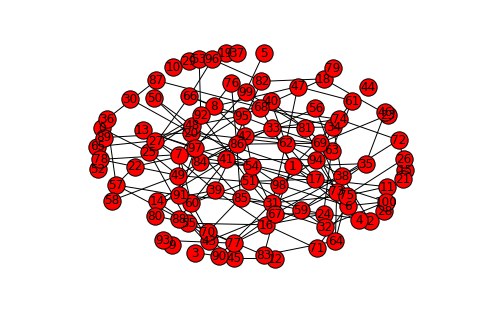

In [24]:
'''
Sample function 1 calling
Change parameters to fit neural model
Computes weighted adjacency matrix

Parameters to be user-defined:
    n: nodes
    m: edges
    k: neighbor connections
    p: probability 
    d: degrees
    
Returns:
    A_neg: Adjacency matrix with excitatory & inhibitory. Numpy array
    W_n: Weighted matrix. Numpy array
    W: Weighted adjacency matrix. Numpy array
'''
n = 101 #Neurons 0 to 100
m = 176
k = 2
p = 0.2
d = 2

Adj = AdjacencyMatrix(n) # Initiates 

#[A,G] = Adj.all_to_all(n) # Defines all-to-all topology
[A,G] = Adj.random(n,m) # Defines random topology
#[A,G] = Adj.small_world(n,k,p) # Defines small-world topology
#[A,G] = Adj.regular(d,n) # Defines regular topology
#[A,G] = Adj.scale_free(n) # Defines scale-free topology

W,W_n,A_neg,rows,cols,connect_W = Adj.Weighted(A,n) # Output

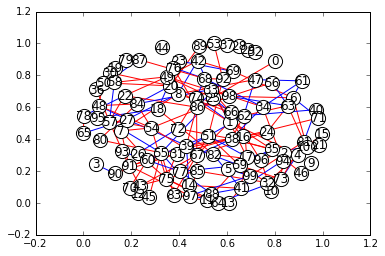

In [25]:
'''
Sample function 2 calling
First plot: cluster coefficient for each neuron
Second plot: excitatory (r) and inhibitory (b) connections
'''
vis = Visualization() # Initiates 
cc_avg = vis.cluster_coeff(G) # Calculates average cluster coefficient
vis.ex_in_connec(G) # Plots excitatory/inhibitory connections
cpl_avg = vis.char_path_len(G) # Calculates average characteristic path length

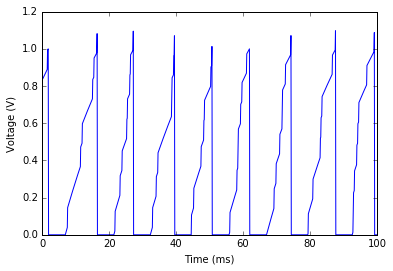

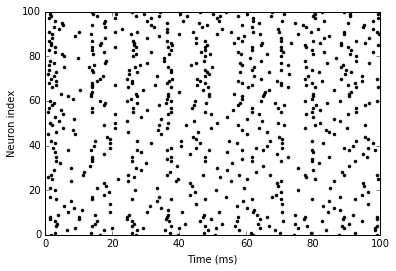

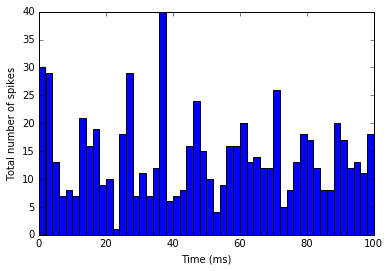

In [26]:
'''
Sample function 4 calling
Change parameters to fit neural model
Simulates leaky integrate-and-fire neuron model

Parameters:
    N: number of neurons
    tau_m: time constant (ms)
    v_r = reset membrane potential (mv)
    v_th = threshold membrane potential (mv)
    I_c = constant input current
    run_time = simulation time (ms)
'''
        
N = n 
tau_m = 30
v_r = 0 
v_th = 1 
I_c = 2 
run_time = 100

BrianVis = BrianVisualization() # Initiates

[statemon,spikemon,G] = BrianVis.LIF_model(rows,cols,connect_W) # Runs LIF model on neurons

#[statemon,spikemon,G,spikemon_subG] = BrianVis.LIF_model(rows,cols,connect_W) # Runs LIF model on neurons

[spike_times,all_spikes] = BrianVis.spike_time(spikemon) # Determines spike times

plt.figure(1)
BrianVis.voltage_monitor(statemon) # Plots voltage monitor

plt.figure(2)
BrianVis.raster_plot(spikemon) # Plots raster plot

plt.figure(3)
BrianVis.spike_hist(run_time,all_spikes) # Plots histogram